In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

In [2]:
#read from google drive
data=pd.read_csv("https://drive.google.com/uc?export=download&id=1nhZhMk_2SIpP8e1_xXLPmWxB52v-sA6w")

In [3]:
#fix ip address
data['ip_address']=round(data['ip_address'])
  
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
data.shape

(151112, 11)

In [5]:
#Read from google drive
ip_addresses=pd.read_csv("https://drive.google.com/uc?export=download&id=1rzr6aVDHlSuKFZHOvE6wJI-yzv7ICYuY")
  
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## For each user, determine their country based on the IP address

In [6]:
def get_country_by_ip_address(data, ip_addresses):
    #### Get Country by ip address
    data_country = []
    for i in range(data.shape[0]):
        tmp = ip_addresses[(ip_addresses['lower_bound_ip_address'] <= data['ip_address'][i])
                                        &(ip_addresses['upper_bound_ip_address'] >= data['ip_address'][i])]['country'].values
        if len(tmp) != 0:
            data_country.append(tmp)
        else:
            data_country.append('na')
    data['country'] = data_country
    data['country'] = data['country'].str.get(0)
    return data

In [7]:
data = get_country_by_ip_address(data, ip_addresses)

## Exploratory data analysis & Feature Engineering

###      Create New Features 1

In [10]:
def create_new_features(data):
    #make datatime string to datetime format
    data["signup_time"] = pd.to_datetime(data["signup_time"])
    data["purchase_time"] = pd.to_datetime(data["purchase_time"])
    
    #purchase time minus sign up time
    data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()
    
    #if the device is shared by multiple users
    data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
    
    #it the ip address us shared by multiple users
    data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')
    
    #Time since the last order purchased by one single ip_address & device_id (too slow)
    time_diff_last_order_ip_address = data[['purchase_time', 'ip_address', 'class']]
    time_diff_last_order_ip_address = time_diff_last_order_ip_address.groupby('ip_address').apply(lambda x: (x['purchase_time'] - x['purchase_time'].shift(+1)).dt.seconds).reset_index()
    time_diff_last_order_ip_address.columns = ['ip_address', 'index', 'time_diff_last_order']
    time_diff_last_order_ip_address = time_diff_last_order_ip_address.set_index('index')
    data['time_diff_last_order_ip_address'] = time_diff_last_order_ip_address['time_diff_last_order']
    
    #Cumulative  number of order placed by device id & by ip address
    data.sort_values('purchase_time', inplace=True)
    data['device_id_cumcount_purchase_time'] = data.groupby('device_id').cumcount()
    data['ip_address_cumcount_purchase_time'] = data.groupby('ip_address').cumcount()
    
    #Cumulative  purchase_value orderd from single ip address & device id
    data['ip_address_cumsum_purchase_value'] = data.groupby('ip_address')['purchase_value'].cumsum()
    data['device_id_cumsum_purchase_value'] = data.groupby('device_id')['purchase_value'].cumsum()
    
    #Total purchase_value orderd from single ip address & device id
    ip_address_sum_purchase_value = data.groupby('ip_address')['purchase_value'].sum().reset_index()
    ip_address_sum_purchase_value.columns  = ['ip_address', 'purchase_value_ip_address']
    data = ip_address_sum_purchase_value.merge(data, how = 'right', right_on = 'ip_address', left_on = 'ip_address')

    device_id_sum_purchase_value = data.groupby('device_id')['purchase_value'].sum().reset_index()
    device_id_sum_purchase_value.columns  = ['device_id', 'purchase_value_device_id']
    data = device_id_sum_purchase_value.merge(data, how = 'right', right_on = 'device_id', left_on = 'device_id')
    
    #time/day of week/month
    data['purchase_time_hour'] = data['purchase_time'].map(lambda x: x.hour)
    data['purchase_time_week'] = data['purchase_time'].map(lambda x: x.strftime('%A'))
    data['purchase_time_Month'] = data['purchase_time'].map(lambda x: x.strftime('%B'))
    return data

In [11]:
data = create_new_features(data)

In [15]:
print("Fraudent order percentage: %1.4f"%(data['class'].mean()*100)+ '%')

Fraudent order percentage: 9.3646%


#### 1. Fraud purchases have lower time difference between sign up time and purchase

<AxesSubplot:xlabel='class', ylabel='purchase_signup_diff'>

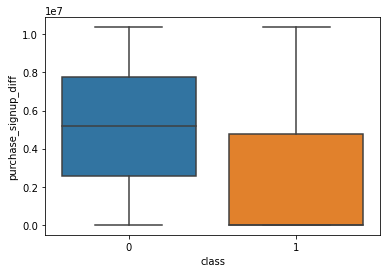

In [16]:
sns.boxplot(x='class', y='purchase_signup_diff', data=data)

#### 2. Fraudulent Orders usually ordered by different user from similar device or ip address

<AxesSubplot:xlabel='class', ylabel='device_id_count'>

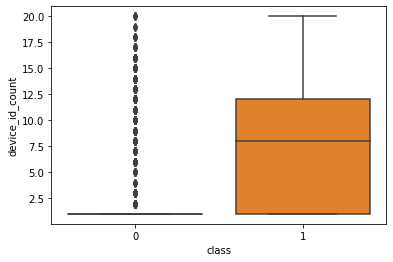

In [17]:
sns.boxplot(x='class', y='device_id_count', data=data)

In [18]:
# data[data['class'] == 1].sort_values(by = ['device_id_count'], ascending=False)[['device_id', 'device_id_count']].head(10)

<AxesSubplot:xlabel='class', ylabel='ip_address_count'>

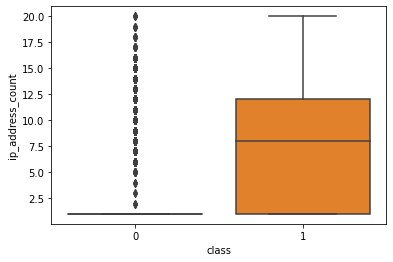

In [19]:
sns.boxplot(x='class', y='ip_address_count', data=data)

#### 3. Time since the last order purchased by one single ip_address & device_id (too slow) - Fraud orders may be purchased together 
* fraudulent orders are usually purchased in bulk or by an account inactive for a long time

In [26]:
fraud = data[(~data['time_diff_last_order_ip_address'].isnull())&(data['class']==1)]['time_diff_last_order_ip_address']
not_fraud = data[(~data['time_diff_last_order_ip_address'].isnull())&(data['class']==0)]['time_diff_last_order_ip_address']

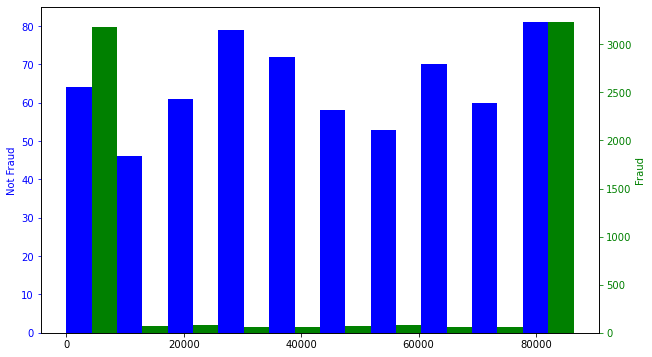

In [27]:
colors = ['b','g']
#sets up the axis and gets histogram data
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.hist([not_fraud, fraud], color=colors)
n, bins, patches = ax1.hist([not_fraud, fraud])
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.5
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Not Fraud", color=colors[0])
ax2.set_ylabel("Fraud", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
# plt.tight_layout()
plt.show()

In [28]:
print("Fraudulent order percentage for orders have null time_diff_last_order_ip_address value is: %1.4f"%(data[data['time_diff_last_order_ip_address'].isnull()]['class'].mean()*100)+ '%')
print('\n')
print("Average time_diff_last_order_ip_address for Fraudulent orders and Non-Fraudulent Orders:")
data[~data['time_diff_last_order_ip_address'].isnull()].groupby('class')['time_diff_last_order_ip_address'].mean()

Fraudulent order percentage for orders have null time_diff_last_order_ip_address value is: 5.0129%


Average time_diff_last_order_ip_address for Fraudulent orders and Non-Fraudulent Orders:


class
0    44612.029503
1    43455.287911
Name: time_diff_last_order_ip_address, dtype: float64

* Most of the orders that have null time_diff_last_order_ip_address value are not Fraudulent Orders. Also, most Fraudulent orders' time_diff_last_order_ip_address values are at the ends of the above histogram. So I will fill the null values with the average of non-fraudulent orders' time_diff_last_order_ip_address amount.

In [31]:
def fiil_time_diff_last_order_ip_address(df):
    m = df[(~df['time_diff_last_order_ip_address'].isnull()) & 
             (df['class'] == 0)]['time_diff_last_order_ip_address'].mean()
    df['time_diff_last_order_ip_address'] = df['time_diff_last_order_ip_address'].fillna(value=m)
    return df

In [32]:
data = fiil_time_diff_last_order_ip_address(data)

44612.029503105565


#### 4. Total purchase_value orderd from single ip address & device id

<AxesSubplot:xlabel='class', ylabel='purchase_value_ip_address'>

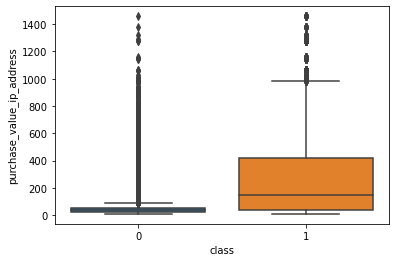

In [39]:
sns.boxplot(x='class', y='purchase_value_ip_address', data=data)

<AxesSubplot:xlabel='class', ylabel='purchase_value_device_id'>

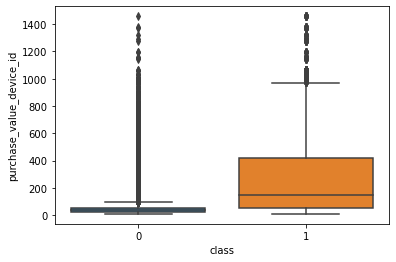

In [40]:
sns.boxplot(x='class', y='purchase_value_device_id', data=data)

#### 5. time/day of week/month
* In January, 76.48% of the orders are fraudulent. This is a serious condition which we need to investigate further.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Thursday'),
  Text(1, 0, 'Wednesday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Sunday'),
  Text(4, 0, 'Monday'),
  Text(5, 0, 'Friday'),
  Text(6, 0, 'Saturday')])

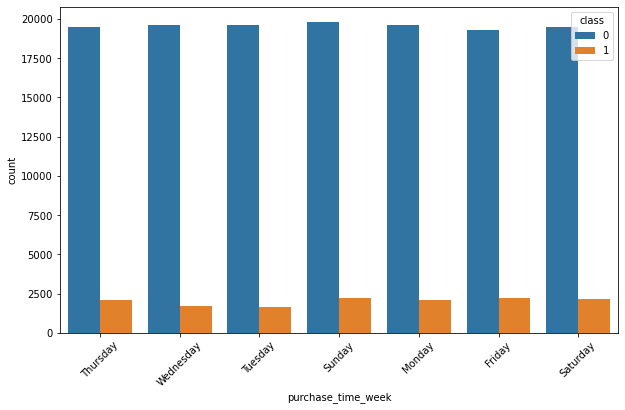

In [43]:
plt.subplots(figsize=(10, 6))
p = sns.countplot(x='purchase_time_week', hue="class", data=data)
plt.xticks(rotation=45)

<AxesSubplot:>

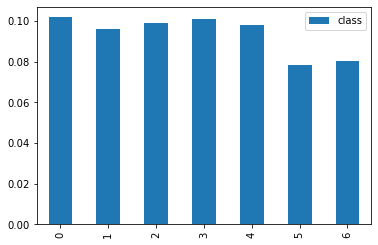

In [44]:
data.groupby(['purchase_time_week'])['class'].mean().reset_index().plot(kind = 'bar')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'January'),
  Text(1, 0, 'March'),
  Text(2, 0, 'February'),
  Text(3, 0, 'April'),
  Text(4, 0, 'June'),
  Text(5, 0, 'August'),
  Text(6, 0, 'July'),
  Text(7, 0, 'October'),
  Text(8, 0, 'May'),
  Text(9, 0, 'November'),
  Text(10, 0, 'September'),
  Text(11, 0, 'December')])

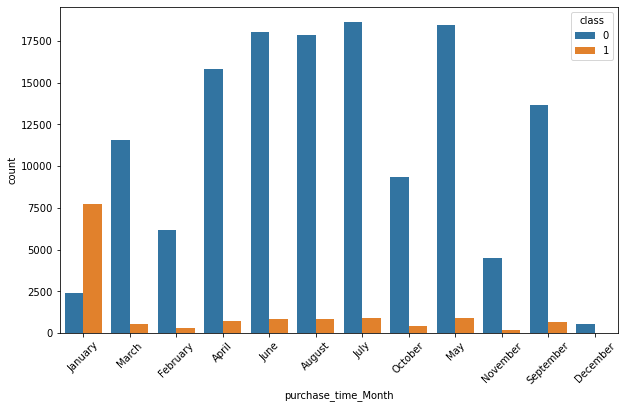

In [45]:
plt.subplots(figsize=(10, 6))
p = sns.countplot(x='purchase_time_Month', hue="class", data=data)
plt.xticks(rotation=45)

<AxesSubplot:>

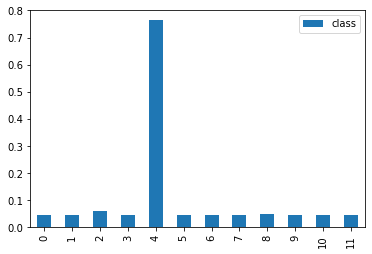

In [46]:
data.groupby(['purchase_time_Month'])['class'].mean().reset_index().plot(kind = 'bar')

In [47]:
data.groupby(['purchase_time_Month'])['class'].mean()

purchase_time_Month
April        0.044710
August       0.044636
December     0.060449
February     0.045123
January      0.764881
July         0.046137
June         0.044531
March        0.045079
May          0.047562
November     0.045541
October      0.045033
September    0.046212
Name: class, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

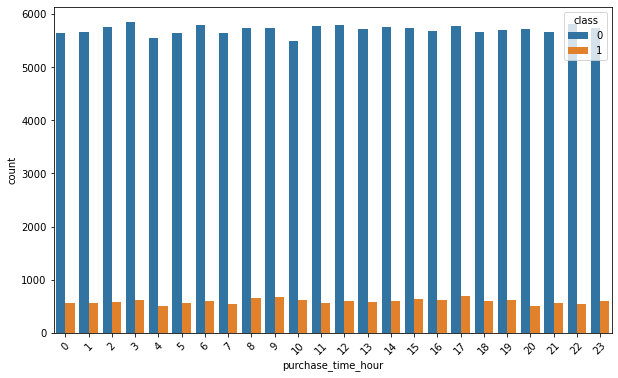

In [48]:
plt.subplots(figsize=(10, 6))
p = sns.countplot(x='purchase_time_hour', hue="class", data=data)
plt.xticks(rotation=45)

In [49]:
# data.groupby(['purchase_time_hour'])['class'].mean().reset_index()

<AxesSubplot:xlabel='purchase_time_hour'>

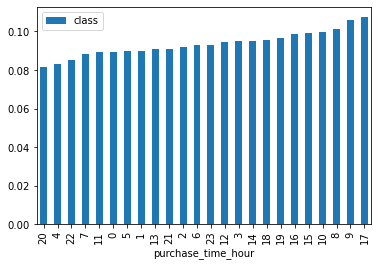

In [50]:
data.groupby(['purchase_time_hour'])['class'].mean().reset_index().sort_values(by = 'class').plot(kind = 'bar', x = 'purchase_time_hour', y = 'class')

#### 6. Country

In [400]:
country_fraud_per = data.groupby('country')['class'].mean().reset_index().sort_values('class', ascending=False)
country_fraud_count = data.groupby('country').size().reset_index().sort_values(0, ascending=False)
country_fraud = country_fraud_per.merge(country_fraud_count)
country_fraud.columns = ['country', 'fraud_percentgae', 'order_count']
country_fraud = data.groupby('country')['purchase_value'].sum().reset_index().merge(country_fraud)

<AxesSubplot:xlabel='fraud_percentgae', ylabel='order_count'>

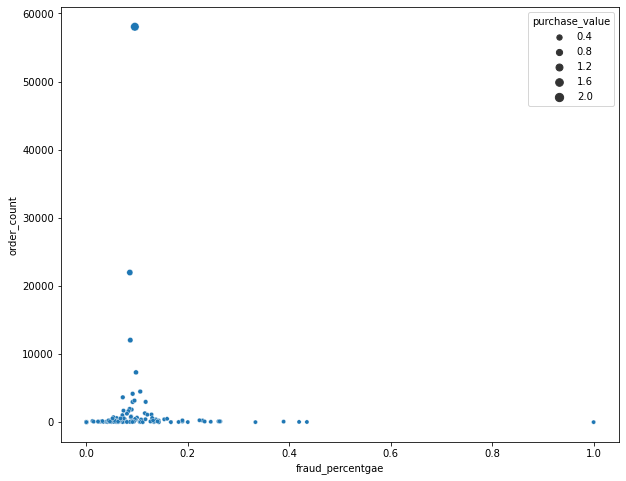

In [401]:
fig, ax1 = plt.subplots(figsize=(10, 8))
sns.scatterplot(data = country_fraud, x = 'fraud_percentgae', y = 'order_count', size='purchase_value')

In [395]:
# fig, ax1 = plt.subplots(figsize=(15, 8))
# country_fraud['order_count'].plot(kind='bar', color='y', secondary_y=True)
# country_fraud['fraud_percentgae'].plot(kind='line', marker='d')

#### 7. Age

<AxesSubplot:xlabel='class', ylabel='age'>

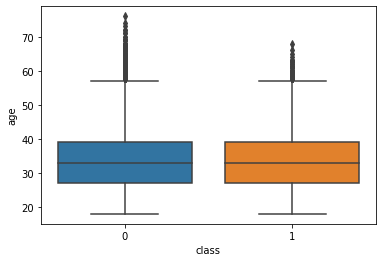

In [54]:
sns.boxplot(x='class', y='age', data=data)

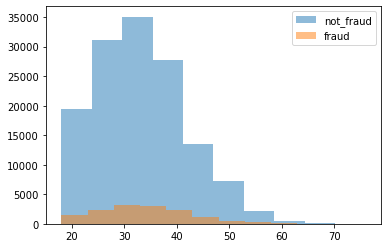

In [55]:
fraud = data[data['class']==1]['age']
not_fraud = data[data['class']==0]['age']
plt.hist(not_fraud, alpha = 0.5, label = 'not_fraud')
plt.hist(fraud, alpha = 0.5, label = 'fraud')
plt.legend(loc='best')

#### 8. Sex

<AxesSubplot:xlabel='sex', ylabel='count'>

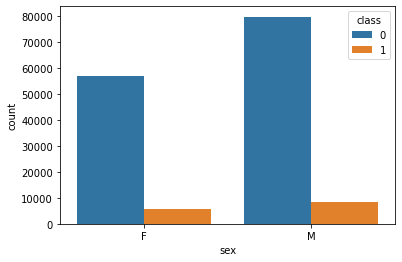

In [56]:
sns.countplot(x="sex", hue="class", data=data)

In [57]:
data.groupby(["sex", "class"]).size()/data.groupby(["sex"]).size()

sex  class
F    0        0.908993
     1        0.091007
M    0        0.904477
     1        0.095523
dtype: float64

In [58]:
data.groupby(["class", "sex"]).size()/data.groupby(["class"]).size()

class  sex
0      F      0.416922
       M      0.583078
1      F      0.404000
       M      0.596000
dtype: float64

#### 9. Source

In [59]:
data['source'].unique()

array(['Ads', 'SEO', 'Direct'], dtype=object)

<AxesSubplot:xlabel='class', ylabel='count'>

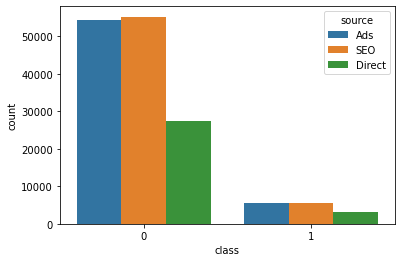

In [60]:
sns.countplot(x='class', hue='source', data=data)

#### 10. Fraudulent Order Percentage by ip_address & device_id

* Fraudsters placed multiple fraudulent orders from one ip_address and/or device_id to boost their earnings.

In [281]:
def fraud_order_percentage(data, device_id_or_ip_address = 'device_id'):

    device_id_fraud_per = pd.DataFrame(data[data['class'] == 1].groupby(device_id_or_ip_address).size()/data.groupby(device_id_or_ip_address).size(), columns = ['%fraud']).fillna(0).reset_index()

    device_id_order_count = data.groupby(device_id_or_ip_address).size()
    device_id_order_count = device_id_order_count.reset_index()
    device_id_order_count.columns = [device_id_or_ip_address, '#orders']

    device_id = device_id_order_count.merge(device_id_fraud_per)

    device_id_weight = device_id.groupby(['#orders', '%fraud']).size().reset_index()
    device_id_weight.columns = ['#orders', '%fraud', 'weight']
    return device_id_weight

<AxesSubplot:xlabel='#orders', ylabel='%fraud'>

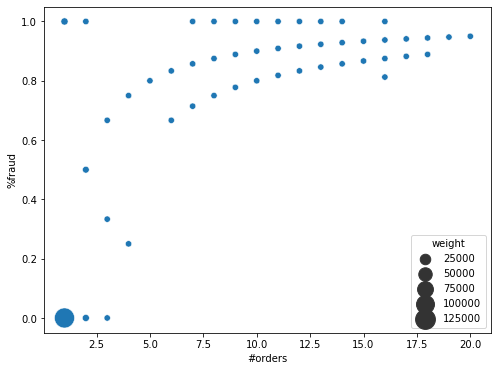

In [283]:
device_id_weight = fraud_order_percentage(data, 'device_id')

fig, ax1 = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=device_id_weight, x='#orders', y='%fraud', size='weight',
            sizes=(40, 400))

<AxesSubplot:xlabel='#orders', ylabel='%fraud'>

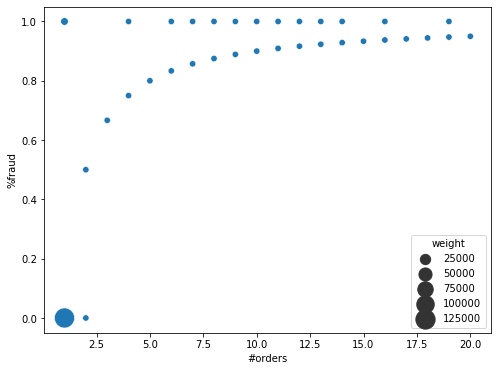

In [284]:
device_id_weight = fraud_order_percentage(data, 'ip_address')

fig, ax1 = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=device_id_weight, x='#orders', y='%fraud', size='weight',
            sizes=(40, 400))

#### Analysis 1 - Fraudulent Orders in January
* Utilize Decision Tree to find the main source of Fraud on January

P.S. class_weight: https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/

In [139]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [140]:
data_january = data[data['purchase_time_Month'] == 'January']
data_january.shape

(10097, 25)

In [141]:
print(data_january.groupby('class').size())
print(data_january['class'].mean())

class
0    2374
1    7723
dtype: int64
0.7648806576210756


In [142]:
def other_countries(data, n = 40):
    bottom_countries = data.groupby('country').size().sort_values(ascending=False)[50:].index
    countries_other = dict.fromkeys(bottom_countries, 'Others')
    data['country'] = data['country'].replace(countries_other)
    return data

data_january = other_countries(data_january, 40)

<ipython-input-142-21c7e4816415>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['country'] = data['country'].replace(countries_other)


In [143]:
data_january_tree = data_january.drop(['device_id', 'ip_address', 'user_id', 'signup_time', 
                                       'purchase_time', 'country', 'purchase_time_hour'],axis=1)

In [144]:
data_january_tree.shape

(10097, 18)

In [145]:
data_january_tree.describe().T

,count,mean,std,min,25%,50%,75%,max
purchase_value_device_id,10097.0,353.076458,287.933643,9.0,110.0,288.000000,516.0,1458.0
purchase_value_ip_address,10097.0,350.133802,286.829816,9.0,105.0,288.000000,512.0,1458.0
purchase_value,10097.0,36.783005,18.304909,9.0,22.0,34.000000,49.0,115.0
age,10097.0,33.407943,8.621330,18.0,27.0,33.000000,39.0,74.0
class,10097.0,0.764881,0.424094,0.0,1.0,1.000000,1.0,1.0
purchase_signup_diff,10097.0,218922.282262,493915.068194,1.0,1.0,1.000000,1.0,2656062.0
device_id_count,10097.0,9.501832,5.371262,1.0,6.0,11.000000,13.0,20.0
ip_address_count,10097.0,9.426166,5.367324,1.0,6.0,11.000000,13.0,20.0
time_diff_last_order_ip_address,10097.0,43786.183565,34754.953242,1.0,7.0,44612.029503,86394.0,86399.0
device_id_cumcount_purchase_time,10097.0,3.920471,3.887548,0.0,0.0,3.000000,7.0,19.0


In [146]:
data_january_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10097 entries, 0 to 10925
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   purchase_value_device_id           10097 non-null  int64  
 1   purchase_value_ip_address          10097 non-null  int64  
 2   purchase_value                     10097 non-null  int64  
 3   source                             10097 non-null  object 
 4   browser                            10097 non-null  object 
 5   sex                                10097 non-null  object 
 6   age                                10097 non-null  int64  
 7   class                              10097 non-null  int64  
 8   purchase_signup_diff               10097 non-null  float64
 9   device_id_count                    10097 non-null  int64  
 10  ip_address_count                   10097 non-null  int64  
 11  time_diff_last_order_ip_address    10097 non-null  flo

In [147]:
def decisionTree_January_FeartureInportance(df, classWeight):
    df = pd.get_dummies(df, drop_first=True)
    print(df.columns)
    
    data_january_tree_x = df.drop('class', axis = 1)
    data_january_tree_y = df['class']
    
    tree=DecisionTreeClassifier(
    class_weight=classWeight
    )
    
    tree.fit(data_january_tree_x, data_january_tree_y)
    
    featureImportance_dic = dict(zip(data_january_tree_x.columns, tree.feature_importances_))
    return pd.DataFrame.from_dict(featureImportance_dic, 
                                  orient='index', 
                                  columns=['feature_importances']).sort_values(by = 'feature_importances', 
                                                                               ascending=False)

In [148]:
decisionTree_January_FeartureInportance(data_january_tree, {0:3, 1:1})

Index(['purchase_value_device_id', 'purchase_value_ip_address', 'purchase_value', 'age', 'class', 'purchase_signup_diff', 'device_id_count', 'ip_address_count', 'time_diff_last_order_ip_address', 'device_id_cumcount_purchase_time', 'ip_address_cumcount_purchase_time', 'ip_address_cumsum_purchase_value', 'device_id_cumsum_purchase_value',
       'source_Direct', 'source_SEO', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_M', 'purchase_time_week_Monday', 'purchase_time_week_Saturday', 'purchase_time_week_Sunday', 'purchase_time_week_Thursday', 'purchase_time_week_Tuesday', 'purchase_time_week_Wednesday'],
      dtype='object')


,feature_importances
purchase_signup_diff,0.977336
age,0.004615
device_id_cumsum_purchase_value,0.003572
purchase_value_device_id,0.002671
ip_address_cumsum_purchase_value,0.001699
purchase_value_ip_address,0.001482
sex_M,0.001055
source_SEO,0.000813
purchase_time_week_Tuesday,0.000759
source_Direct,0.000750


#### We can find some extraordinary things from the January dataset feature importance compared with the whole dataset distribution.
 * In January, many fraudulent orders were purchased by newly registered accounts. The total purchase values are way larger than non-fraudulent orders'. And most of them registered a new account and then placed orders within a few seconds. They probably did this through a bot.

<AxesSubplot:xlabel='class', ylabel='purchase_value_device_id'>

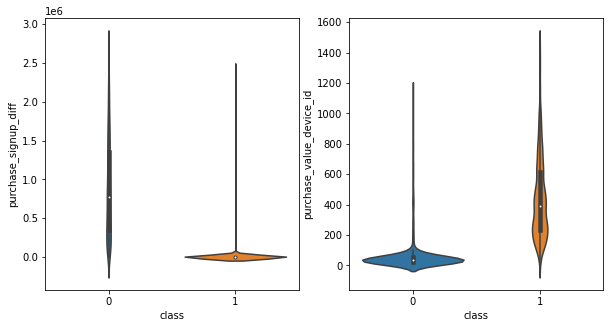

In [174]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.violinplot(x='class', y='purchase_signup_diff', data=data_january, ax=axs[0])
sns.violinplot(x='class', y='purchase_value_device_id', data=data_january, ax=axs[1])

In [166]:
# sns.violinplot(x='class', y='age', data=data_january)

<AxesSubplot:xlabel='purchase_value_device_id', ylabel='purchase_signup_diff'>

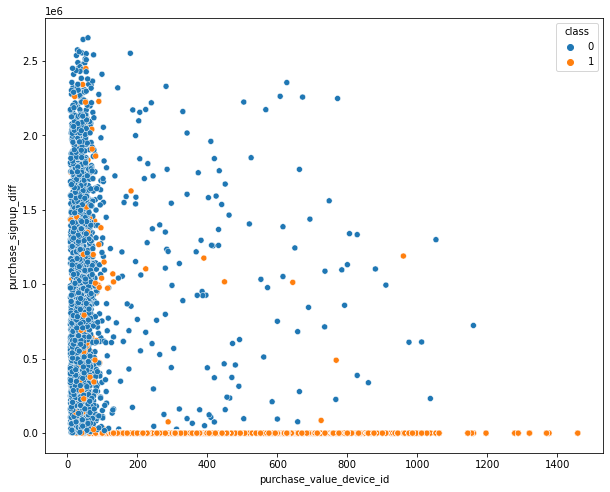

In [168]:
fig, ax1 = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data_january, x='purchase_value_device_id', y='purchase_signup_diff', hue='class')

#### Analysis 2 - Country Segmentation by performance
* Performance Metrics:
 - \# Orders
 - %Fraud(Order Numbers)
 - sum_purchase_value
* Algorithm: 
    - K-Means: Preprocess the features by StandarScaler - Standardize features by removing the mean and scaling to unit variance

In [403]:
country_fraud = country_fraud.set_index('country')
country_fraud_culster = country_fraud.copy()
country_fraud_culster.head()

,purchase_value,fraud_percentgae,order_count
country,,,
Afghanistan,194,0.166667,6
Albania,379,0.000000,13
Algeria,4452,0.106557,122
Angola,836,0.041667,24
Antigua and Barbuda,95,0.000000,3


In [376]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [404]:
scaler = preprocessing.StandardScaler()
country_fraud_transfromed = scaler.fit_transform(country_fraud_culster)

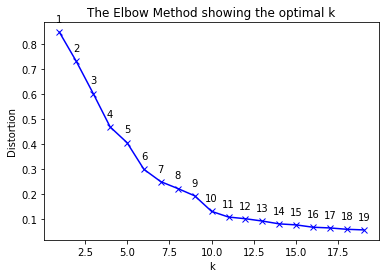

In [406]:
# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(country_fraud_transfromed)
    distortions.append(sum(np.min(cdist(country_fraud_transfromed, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / country_fraud_transfromed.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

# zip joins x and y coordinates in pairs
for x,y in zip(K,distortions):

    label = x

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

In [415]:
# country_fraud_transfromed

In [408]:
kmeanModel = KMeans(n_clusters=10).fit(country_fraud_transfromed)

In [410]:
country_fraud_culster['cluster'] = kmeanModel.predict(country_fraud_transfromed)

In [416]:
# fig, ax1 = plt.subplots(figsize=(10, 8))
# sns.scatterplot(data = country_fraud_culster, x = 'purchase_value', y = 'order_count', size = 'fraud_percentgae', hue='cluster')

In [420]:
country_fraud_culster

,purchase_value,fraud_percentgae,order_count,cluster
country,,,,
Afghanistan,194,0.166667,6,0
Albania,379,0.000000,13,2
Algeria,4452,0.106557,122,0
Angola,836,0.041667,24,9
Antigua and Barbuda,95,0.000000,3,2
...,...,...,...,...
Virgin Islands (U.S.),130,0.333333,3,3
Yemen,26,0.000000,1,2
Zambia,342,0.000000,10,2


<AxesSubplot:xlabel='fraud_percentgae', ylabel='order_count'>

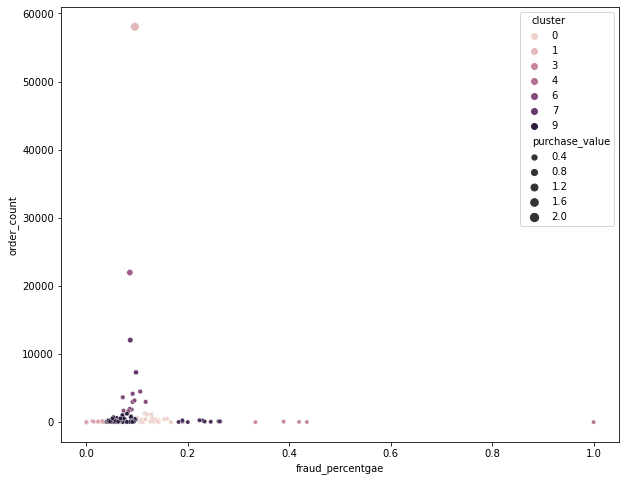

In [414]:
fig, ax1 = plt.subplots(figsize=(10, 8))
sns.scatterplot(data = country_fraud_culster, x = 'fraud_percentgae', y = 'order_count', size = 'purchase_value', hue='cluster')

In [419]:
country_cluster_dict = country_fraud_culster['cluster'].to_dict()

## Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model
* Random Forest
* Gradient Boosting
* XGBoosting
* LightGBM

In [434]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

In [428]:
data_rf = data.drop(['device_id', 'ip_address', 'user_id', 'signup_time', 
                                       'purchase_time', 'purchase_time_hour'] ,axis=1)
data_rf['country'] = data_rf['country'].map(lambda x: country_cluster_dict[x])

In [72]:
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one

# bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index

# x = dict.fromkeys(bottom_countries, 'Other')
# data_rf['country'] = data_rf['country'].replace(x)

In [432]:
data_rf = pd.get_dummies(data_rf, drop_first=True)

In [435]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)

In [436]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

RandomForestClassifier(max_features=3, oob_score=True)

In [438]:
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9560326070608525 
 OOB Confusion Matrix 
        0     1
0  90346    59
1   4326  5002


In [55]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9557990618735281 
 Test Set Confusion Matrix 
        0     1
0  46492    24
1   2247  2616


In [439]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9569279277525837 
 Test Set Confusion Matrix 
        0     1
0  46547     9
1   2204  2619


In [440]:
#We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


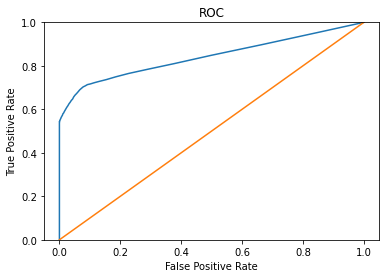

In [441]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [444]:
#For consistency with R, we will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pd.DataFrame({'cutoff':pd.Series(thresholds),
                               'class0_error':pd.Series(fpr),
                               'class1_error': 1 - pd.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
53    0.14      0.078035      0.296703       0.625262


In [445]:
error_cutoff

,cutoff,class0_error,class1_error,optimal_value
0,2.00,0.000000,1.000000,0.000000
1,1.00,0.000000,0.572465,0.427535
2,0.99,0.000000,0.510263,0.489737
3,0.98,0.000000,0.486834,0.513166
4,0.97,0.000000,0.476260,0.523740
...,...,...,...,...
63,0.04,0.377846,0.189509,0.432645
64,0.03,0.498948,0.151565,0.349487
65,0.02,0.664039,0.102841,0.233120
66,0.01,0.852543,0.045407,0.102049


In [447]:
feat_importances = pd.DataFrame(rf.feature_importances_, index=train.drop('class', axis=1).columns)

In [448]:
feat_importances.columns = ['col']

In [449]:
feat_importances.sort_values(by='col' , ascending = False)[:20]

,col
purchase_signup_diff,0.166869
device_id_count,0.085803
purchase_value_device_id,0.083884
ip_address_count,0.066318
ip_address_cumcount_purchase_time,0.063904
age,0.063735
device_id_cumcount_purchase_time,0.061442
purchase_value_ip_address,0.055782
device_id_cumsum_purchase_value,0.052328
ip_address_cumsum_purchase_value,0.048823


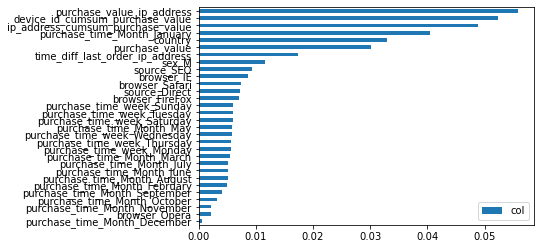

In [450]:
feat_importances.sort_values(by='col' ).head(30).plot(kind='barh')
plt.show()